In [16]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.convolution import convolve,Gaussian2DKernel
from matplotlib import colors

In [17]:
def count2flux(img_count,replacer=1e-10,mag_const=24.37,
               lamda=6563,delta_lamda=250,z=2.3):
    '''
    convert counts map to flux map.
    lamda and delta_lamda in unit of \AA
    '''
    #replace negtive value with positive
    img_count[img_count<=0]=replacer
    
    mag=-2.5*np.log10(img_count)+mag_const
    flux_nu=10**(-(mag+48.6)/2.5)
    flux_lamda=flux_nu*const.c.to(u.AA/u.second).value/((lamda*(1+z))**2)
    flux=flux_lamda*delta_lamda*u.erg/(u.second*(u.cm**2))
    
    return flux

def pix2world(shape,delta,origin_pix,origin_world):
    '''
    convert pixel coordinate to
    ra,dec, origin_pix and origin_world
    is the coordinate of origin in 
    different frame. They are both 1-d
    array with two elements
    return two 1-d arrays of ra and 
    dec respectively
    '''
    
    x,y=np.arange(shape[1]),np.arange(shape[0])
    X,Y=np.meshgrid(x,y)
    ra_map=(origin_pix[0]-X)*delta[0]+origin_world[0]
    dec_map=(origin_pix[1]-Y)*delta[1]+origin_world[1]
    
    return ra_map.mean(axis=0), dec_map.mean(axis=1)

In [18]:
dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/results/'
ly_fits=fits.open(dic+'MAMMOTH-1_cut.fits')
h_fits=fits.open(dic+'MORICS_geotran_cut.fits')

In [19]:
img_flux_h=count2flux(h_fits[0].data)
img_flux_ly=count2flux(ly_fits[0].data,mag_const=22.05,
                       lamda=1216,delta_lamda=45)

smooth the data use a gaussian kernel with size of 12 and standard deviation of 3 corresponding to radius of 1.4"

In [20]:
kernel=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=13,y_size=13)
smoothed_img_flux_h=convolve(img_flux_h.value,kernel)
smoothed_img_flux_ly=convolve(img_flux_ly.value,kernel)

select a region to estimate the noise and construct the SNR map. H$\rm \alpha$ 50:80,50:80; Ly$\rm \alpha$ 50:100,50:100

In [21]:
# I also use calculate the standard deviation of different aperture, the results is similar to this
noise_h=smoothed_img_flux_h[50:100,50:100].std()
noise_ly=smoothed_img_flux_ly[50:100,50:100].std()

img_snr_h=smoothed_img_flux_h/noise_h
img_snr_ly=smoothed_img_flux_ly/noise_ly

remove noise

In [22]:
img_h=smoothed_img_flux_h.copy()
img_ly=smoothed_img_flux_ly.copy()

img_h[img_snr_h<6]=0
img_ly[img_snr_ly<10]=0

In [23]:
img_h[:125,:]=0
img_h[175:,:]=0
img_h[:,:120]=0
img_h[:,200:]=0
img_h[160:200,160:200]=0

In [24]:
img_h.max()

2.3532116e-18

calculate the ratio map

In [25]:
img_ly[img_ly==0]=1.
img_ratio=img_h/img_ly
img_ratio=img_ratio[50:-50,60:-60]

convert physical coordinate to ra,dec

In [26]:
delta=[7.107805249e-05,7.199198278e-05]
origin_pix=[122-50,150-60]
origin_world=[220.352093,40.0526795]
ra,dec=pix2world(img_ratio.shape,delta,origin_pix,origin_world)
delta_ra=(ra-origin_world[0])*u.deg.to(u.arcsecond)
delta_dec=(dec-origin_world[1])*u.deg.to(u.arcsecond)

In [27]:
sources_list=np.array([[220.3517351,40.05269063],
                       [220.3521004,40.05267509],
                       [220.3519736,40.05221132],
                       [220.3520722,40.05297709],
                       
                       [220.3531717,40.05223288],
                       [220.3497255,40.05104434],
                       [220.3492992,40.05225575],
                       [220.3499296,40.05351636],
                       [220.3525,40.0545]])*u.deg
sources_list[:,0]=sources_list[:,0]-0.0002*u.deg
source_name=['source-B','G-3','G-4','G-6','G-5','G-1']
source_name_coor=np.array([[220.3520722,40.05297709],[220.3531717,40.05223288],
                           [220.3497255,40.05104434],[220.3492992,40.05225575],
                           [220.3499296,40.05351636],[220.3525,40.0545]])*u.deg
delta_sources=(sources_list-origin_world*u.deg).to(u.arcsec).value
delta_source_name_coor=(source_name_coor-origin_world*u.deg).to(u.arcsec).value

In [28]:
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/'
np.savetxt(savdic+'H_ly.txt',img_ratio)

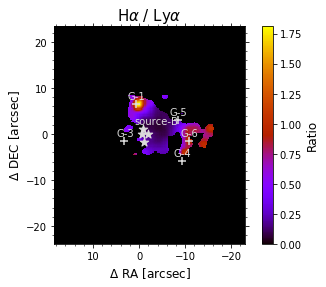

In [21]:
fig_dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
dec_map,ra_map=np.meshgrid(delta_dec,delta_ra)
fig,ax=plt.subplots(1,1)
#plot image and contour
img=ax.pcolormesh(ra_map.T,dec_map.T,img_ratio[::-1,:],
                  cmap='gnuplot')
ax.invert_xaxis()
ax.set_xlabel(r'$\rm \Delta \ RA \ [arcsec]$',fontsize=12)
ax.set_ylabel(r'$\rm \Delta \ DEC \ [arcsec]$',fontsize=12)
ax.set_title(r'H$\alpha$ / Ly$\alpha$',fontsize=15)
#add colorbar
cbar=plt.colorbar(img)
cbar.ax.set_ylabel('Ratio',fontsize=12)
#add sources
for i in range(4):
    ax.scatter(delta_sources[i,0],delta_sources[i,1],marker='*',color='gainsboro',s=80)
for i in range(4,delta_sources.shape[0]):
    ax.scatter(delta_sources[i,0],delta_sources[i,1],marker='+',color='gainsboro',s=80)
for i in range(len(source_name)):
    ax.annotate(source_name[i],xy=(delta_source_name_coor[i,0],delta_source_name_coor[i,1]),
                xytext=(-5,5),textcoords="offset points",color='gainsboro')

ax.set_aspect('equal', adjustable='box')
ax.minorticks_on()
ax.tick_params(axis='both', which='both',top=True,right=True)
fig_dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
plt.savefig(fig_dic+'H_alpha_ly_alpha_ratio.png',dpi=300)
# plt.show()